In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import scipy.stats as stats

import utils
from utils.download import get_data
from utils.var import calculate_var, exceeds_vector, test_exceeds_vector
from utils.methods import weighted_var, garch_var
from utils.tests import scoring_quantile

In [2]:
_ = importlib.reload(utils.download)
_ = importlib.reload(utils.var)

In [3]:
raw_data, params = get_data(yahoo=False)

In [4]:
frequency = params['frequency']
alpha95 = 95
alpha99 = 99

In [5]:
data = raw_data.resample(frequency).last().interpolate(type='linear')

In [6]:
data['returns'] = data.pct_change()

# Metoda historyczna

In [7]:
data = calculate_var(data, lambda x: np.quantile(x, .95), 'hist')
data = calculate_var(data, lambda x: np.quantile(x, .99), 'hist', alpha=alpha99)

Wykres zwrotów i VaR95 dla zwrotów.

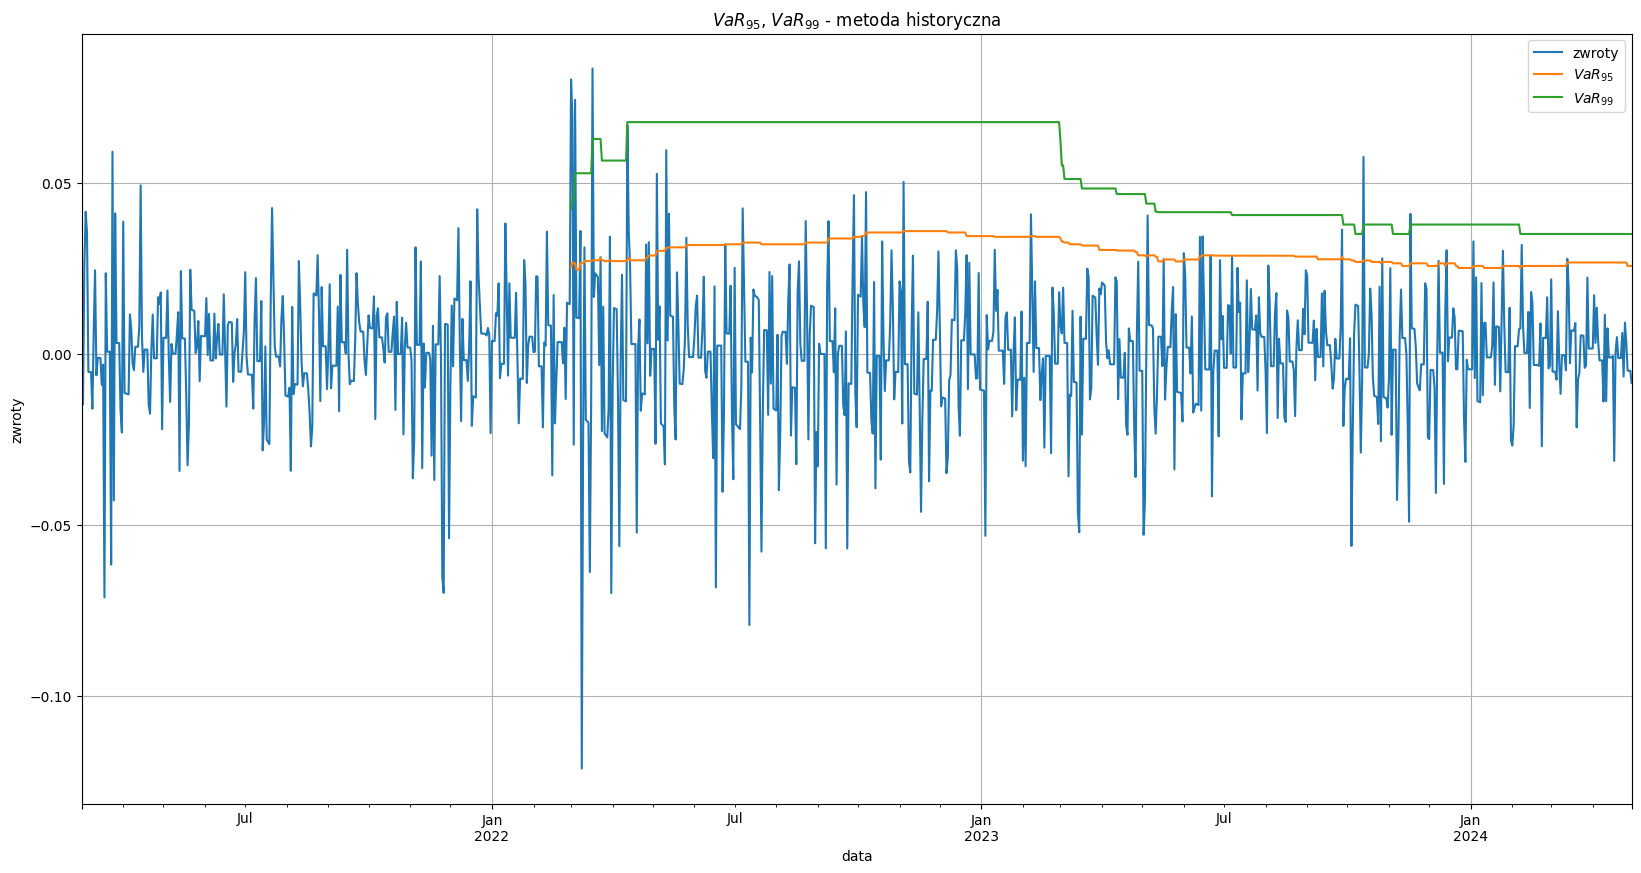

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_hist', 'var99_hist']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$, $VaR_{99}$ - metoda historyczna',
         ylabel='zwroty')
plt.legend(['zwroty', '$VaR_{95}$', '$VaR_{99}$'])
plt.savefig(f"pics\\{params['name']}\\var_zwykla.png")

Wykres cen i VaR95 dla cen.

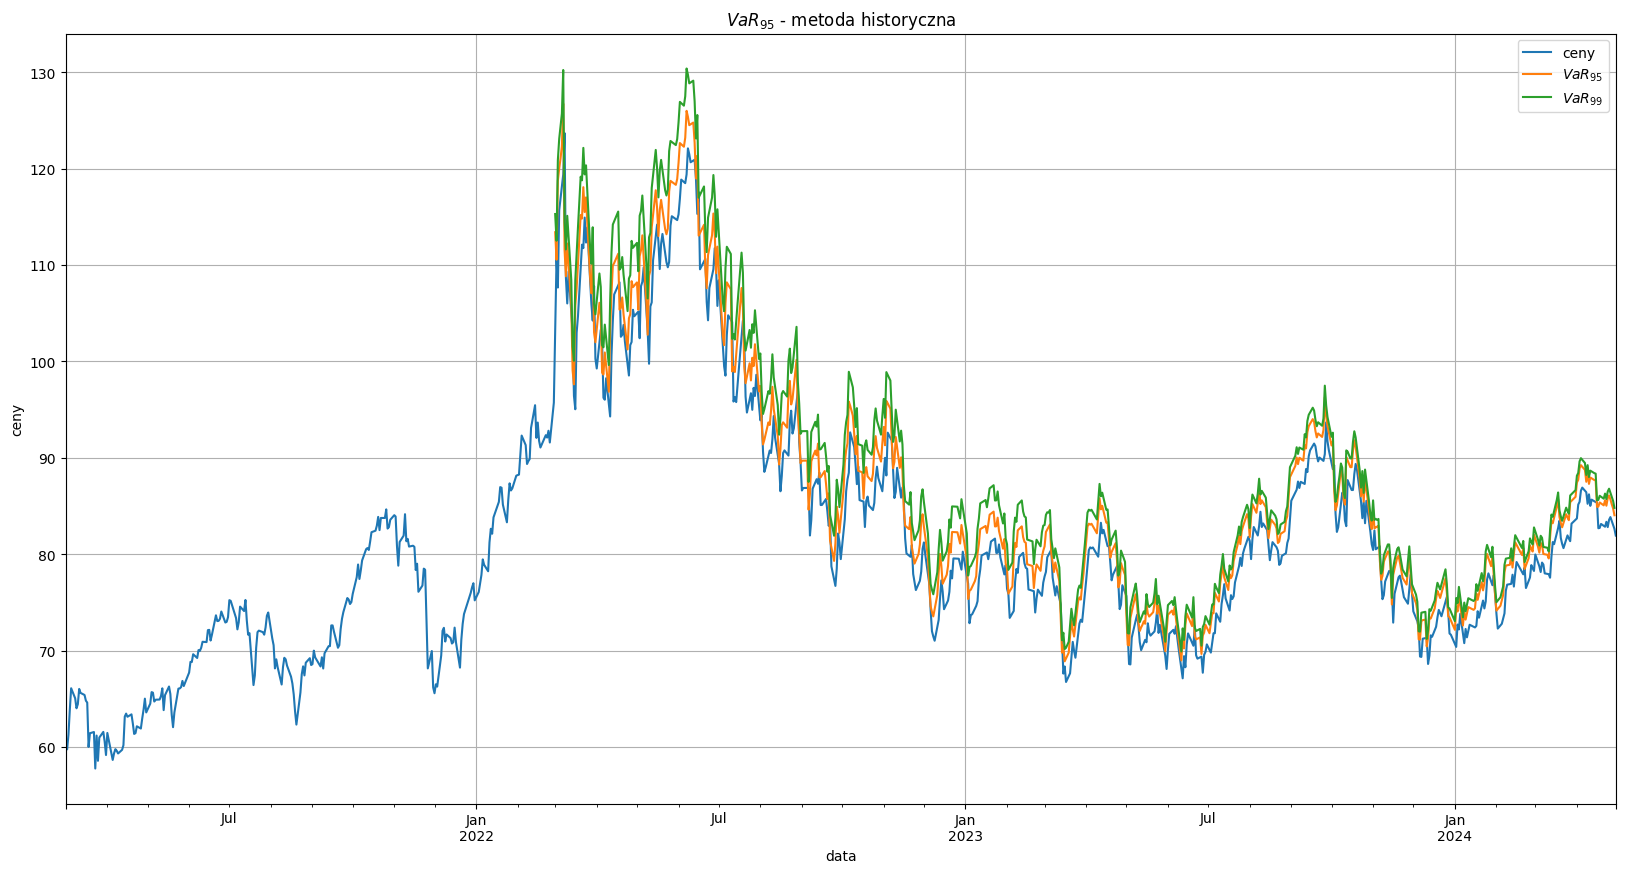

In [9]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['Close', 'VaR95_hist', 'VaR99_hist']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$ - metoda historyczna',
         ylabel='ceny')
plt.legend(['ceny', '$VaR_{95}$', '$VaR_{99}$'])
plt.savefig(f"pics\\{params['name']}\\var_zwykla_ceny.png")

In [10]:
data, I95 = exceeds_vector(data, 'hist')  # I - wektor przekroczeń
data, I99 = exceeds_vector(data, 'hist', alpha99)

Wykres procentu przekroczeń dla okien 50.

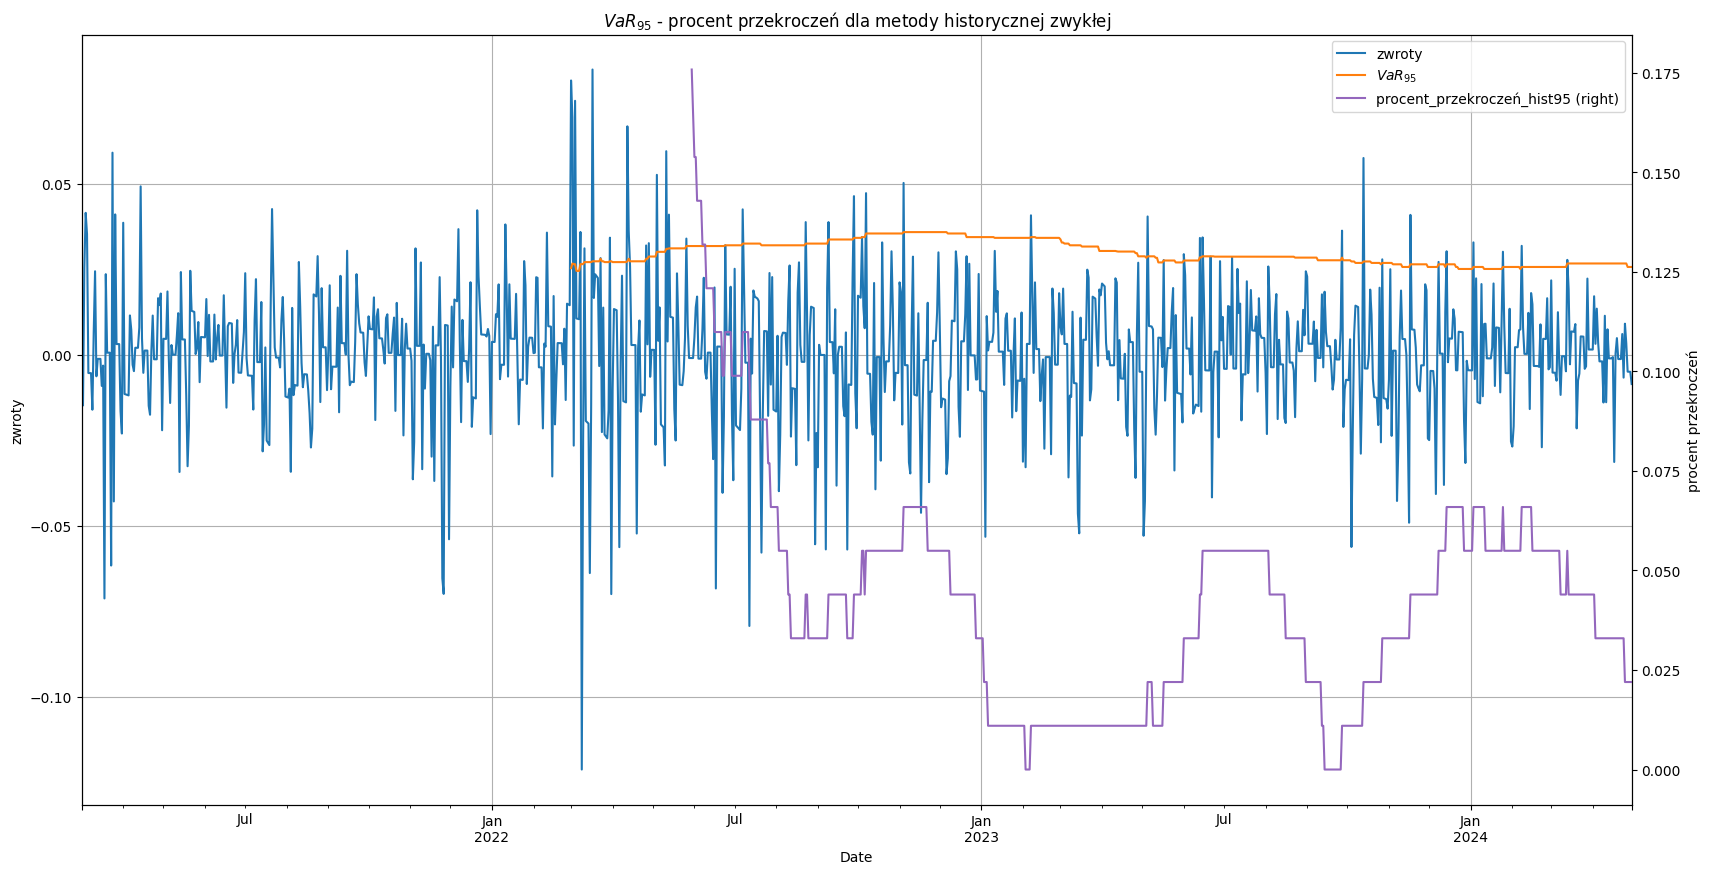

In [11]:
_, ax = plt.subplots(figsize=(20,10))

_ = data[['returns', 'var95_hist']].plot(ax=ax,
                                         grid=True,
                                         style=['-', '-'],
                                         color=['C0', 'C1'],
                                         xlabel='data',
                                         title='$VaR_{95}$ - procent przekroczeń dla metody historycznej zwykłej',
                                         ylabel='zwroty',
                                         legend=True)
plt.legend(['zwroty', '$VaR_{95}$'])

line1 = data[['procent_przekroczeń_hist95']].plot(secondary_y=True,
                                            ax=ax,
                                            color='C4',
                                            ylabel='procent przekroczeń',
                                            legend=True)

plt.savefig(f"pics\\{params['name']}\\procent_zwykla.png")

## Testowanie wsteczne

### Testy oparte o wektor przekroczeń

Kupiec H0: procent przekroczeń = alpha
Christoffersen H0: przekroczenia są niezależne

In [12]:
test_exceeds_vector(I95, .95)

,empiryczne,teoretyczne
średnia,0.050505,0.05
wariancja,0.048015,0.0475
binomtest p-wartość,0.934938,-
Kupiec - p-wartość,0.948085,-
christoffersen p-wartość,1.000000,-


In [13]:
test_exceeds_vector(I99, .99)

,empiryczne,teoretyczne
średnia,0.007576,0.01
wariancja,0.007528,0.0099
binomtest p-wartość,0.718270,-
Kupiec - p-wartość,0.473793,-
christoffersen p-wartość,0.025748,-


# Metoda ważonej symulacji historycznej

In [14]:
data = calculate_var(data, lambda x: weighted_var(x, .95), 'ważona')
data = calculate_var(data, lambda x: weighted_var(x, .99), 'ważona', alpha=alpha99)

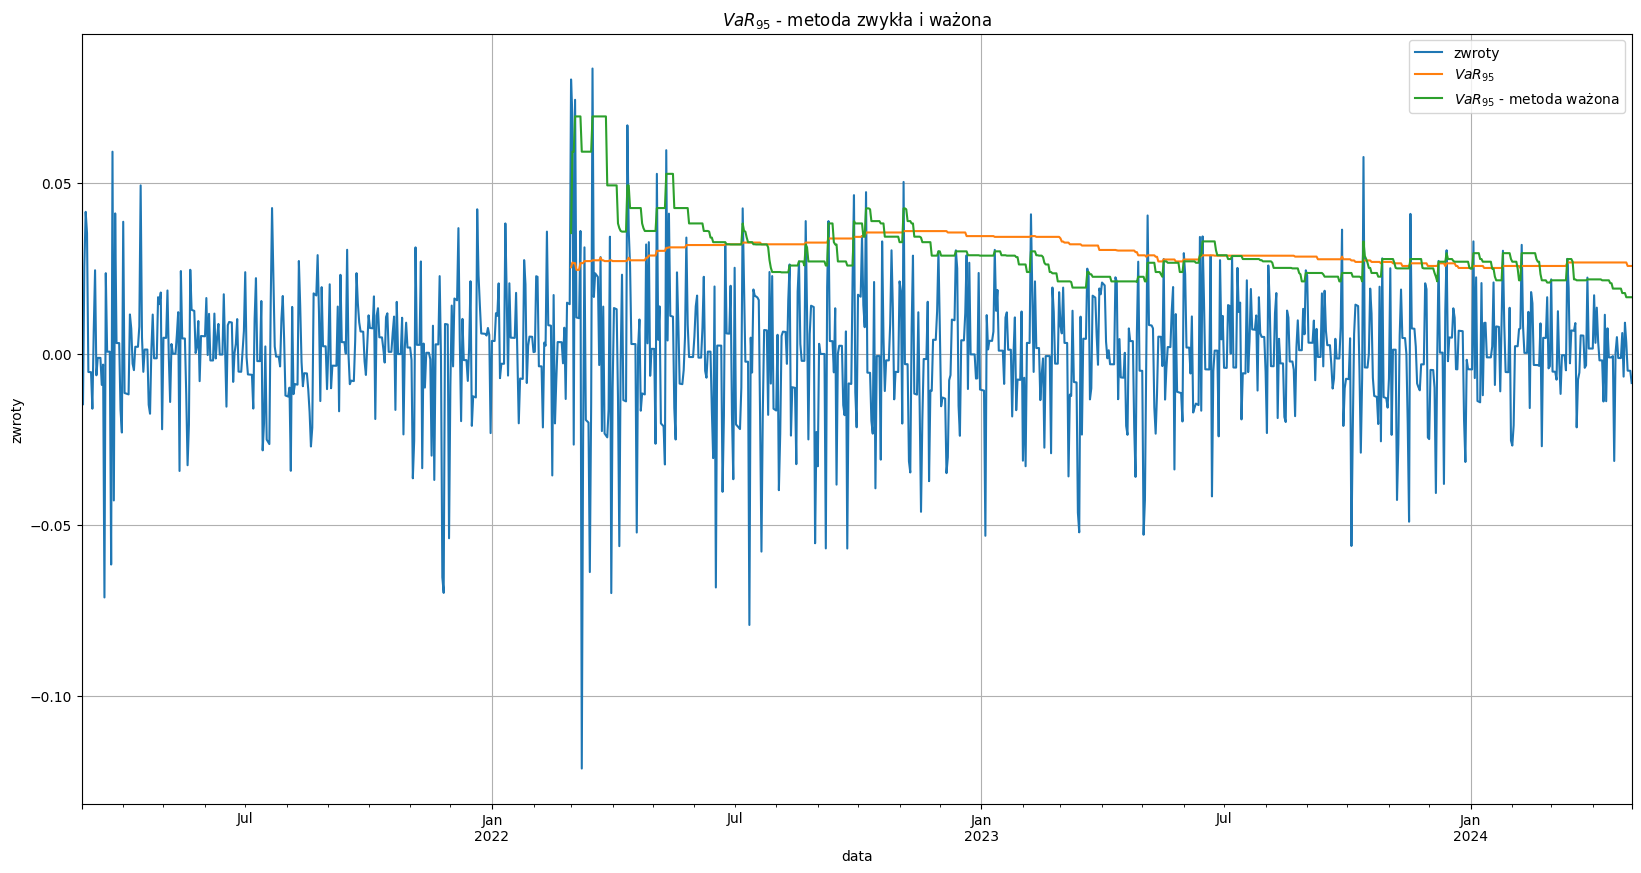

In [15]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_hist','var95_ważona']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$ - metoda zwykła i ważona',
         color=['C0', 'C1', 'C2'],
         ylabel='zwroty')
plt.legend(['zwroty', '$VaR_{95}$', '$VaR_{95}$ - metoda ważona'])
plt.savefig(f'pics\\{params["name"]}\\var_zwykla_wazona.png')

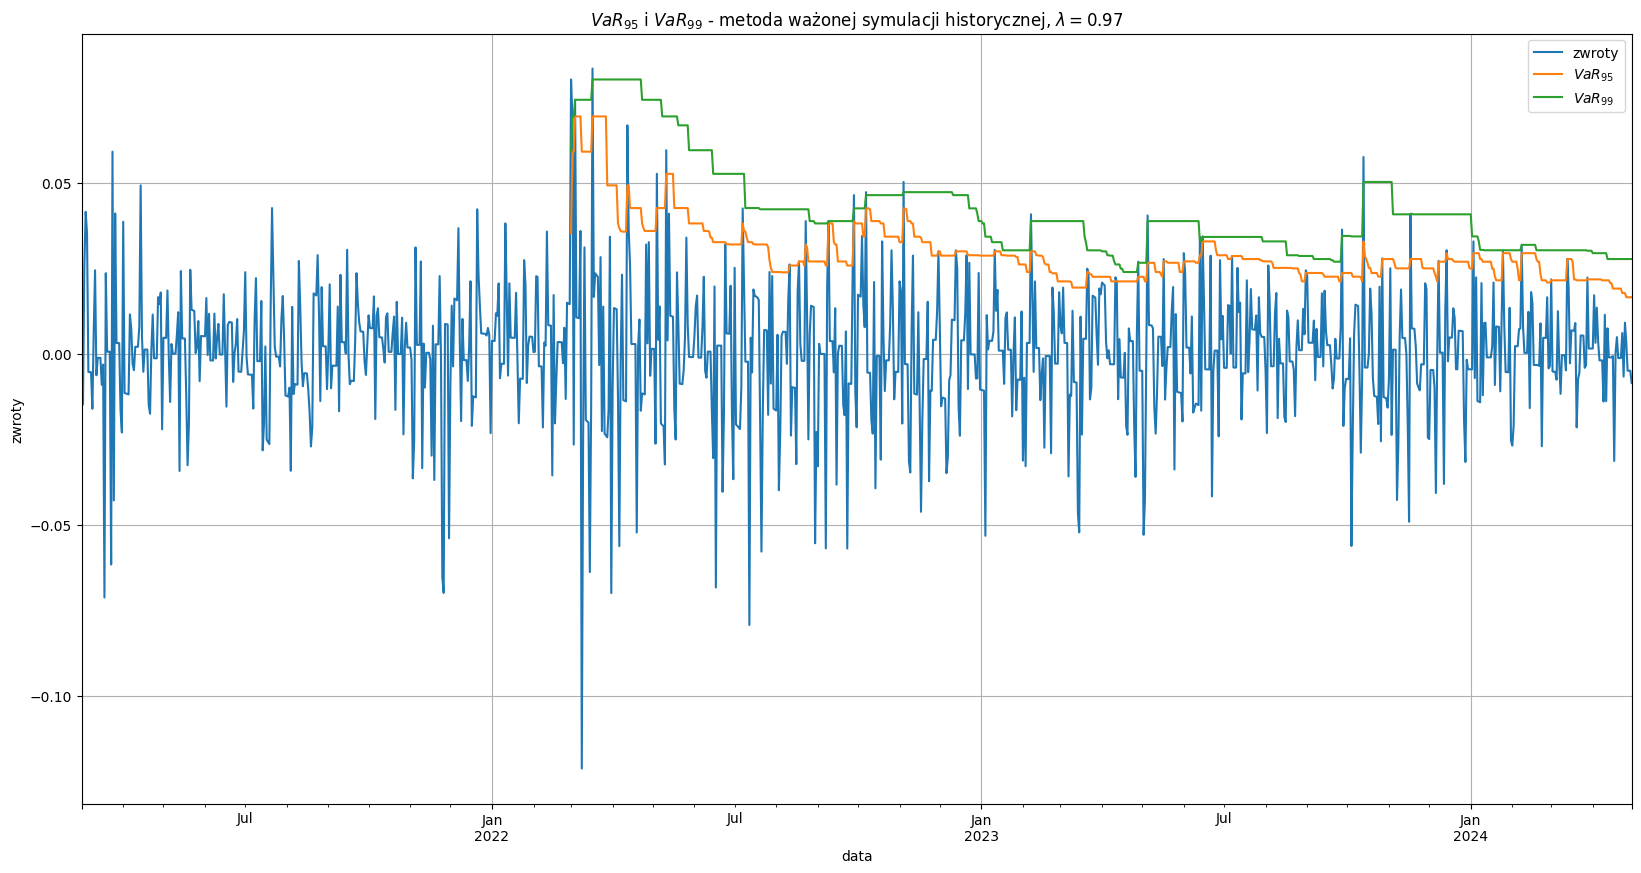

In [16]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_ważona','var99_ważona']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$ i $VaR_{99}$ - metoda ważonej symulacji historycznej, ' + f'$\lambda=${params["lambda"]}',
         color=['C0', 'C1', 'C2'],
         ylabel='zwroty')
plt.legend(['zwroty', '$VaR_{95}$', '$VaR_{99}$'])
plt.savefig(f'pics\\{params["name"]}\\var_wazona.png')

In [17]:
data, I95_weighted = exceeds_vector(data, 'ważona')
data, I99_weighted = exceeds_vector(data, 'ważona', alpha99)

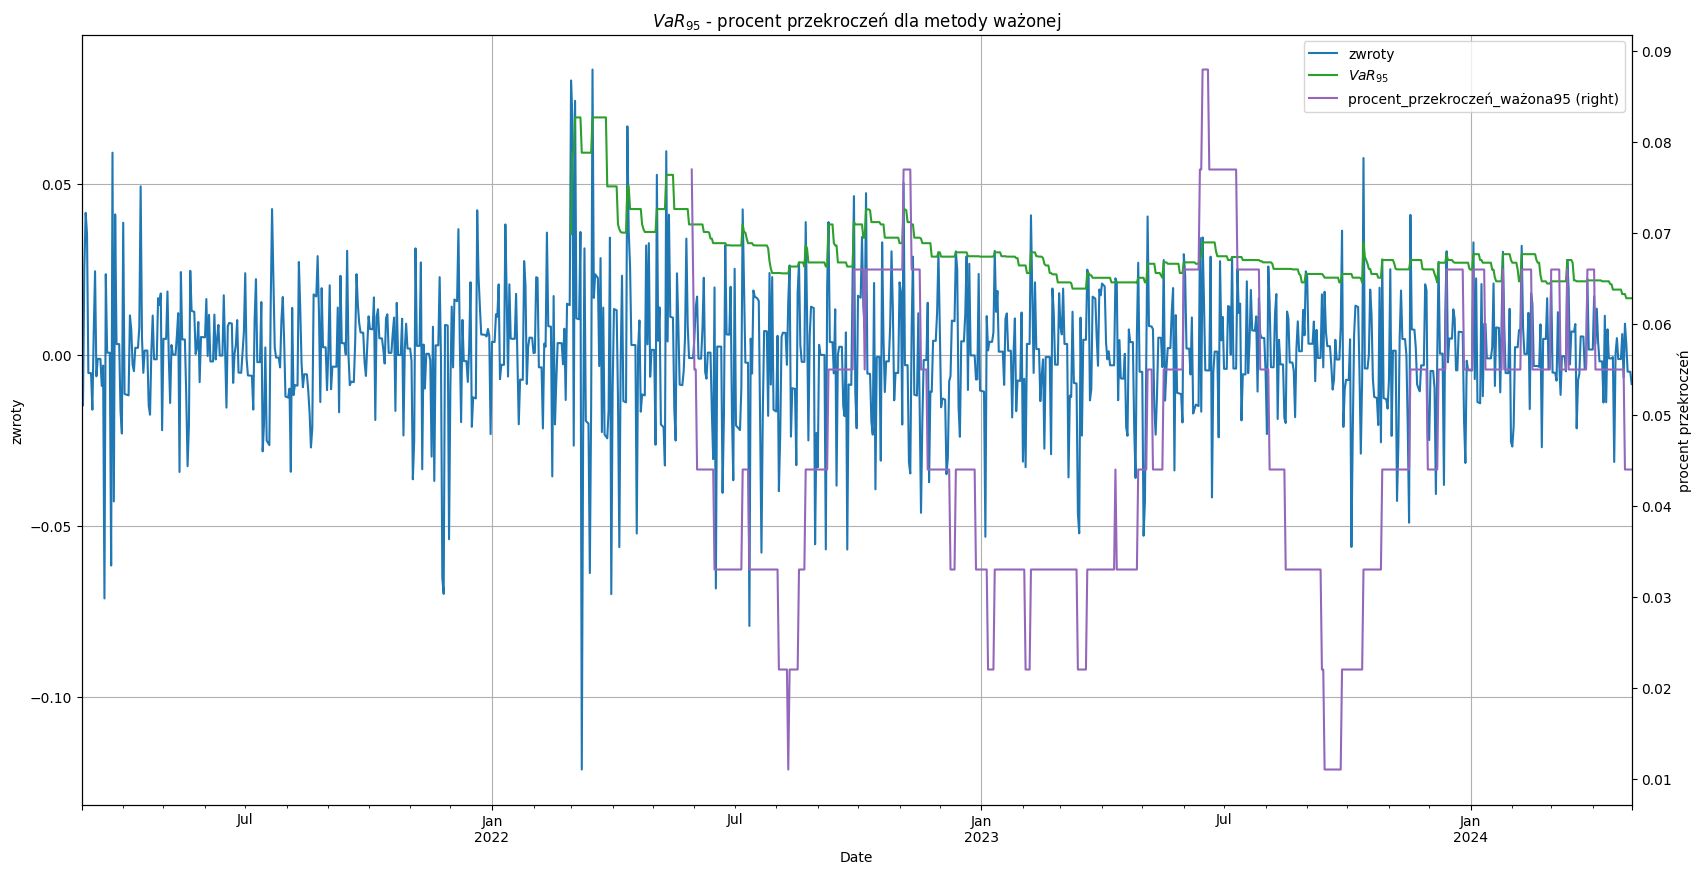

In [18]:
_, ax = plt.subplots(figsize=(20,10))

_ = data[['returns', 'var95_ważona']].plot(ax=ax,
                                           grid=True,
                                           style=['-', '-'],
                                           color=['C0', 'C2'],
                                           xlabel='data',
                                           title='$VaR_{95}$ - procent przekroczeń dla metody ważonej',
                                           legend=True,
                                           ylabel='zwroty')

plt.legend(['zwroty', '$VaR_{95}$'])

_ = data[['procent_przekroczeń_ważona95']].plot(secondary_y=True,
                                                ax=ax,
                                                color='C4',
                                                legend=True,
                                                ylabel='procent przekroczeń')

plt.savefig(f"pics\\{params['name']}\\procent_ważona.png")

## Testowanie wsteczne

### Rozkład dwumianowy

In [19]:
test_exceeds_vector(I95_weighted, .95)

,empiryczne,teoretyczne
średnia,0.049242,0.05
wariancja,0.046877,0.0475
binomtest p-wartość,1.000000,-
Kupiec - p-wartość,0.921886,-
christoffersen p-wartość,0.509254,-


In [20]:
test_exceeds_vector(I99_weighted, .99)

,empiryczne,teoretyczne
średnia,0.016414,0.01
wariancja,0.016165,0.0099
binomtest p-wartość,0.073381,-
Kupiec - p-wartość,0.096800,-
christoffersen p-wartość,0.542856,-


# Metoda filtrowanej symulacji historycznej

In [ ]:
%%capture
data = calculate_var(data, lambda x: garch_var(x, .95), 'garch')
data = calculate_var(data, lambda x: garch_var(x, .99), 'garch', alpha=alpha99)

In [ ]:
data, I95_garch = exceeds_vector(data, 'garch', 95)
data, I99_garch = exceeds_vector(data, 'garch', 99)

In [ ]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_garch','var99_garch']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$ i $VaR_{99}$ - metoda filtrowanej symulacji historycznej',
         color=['C0', 'C1', 'C2'],
         ylabel='zwroty')
plt.legend(['zwroty', '$VaR_{95}$', '$VaR_{99}$'])
plt.savefig(f'pics\\{params["name"]}\\var_garch.png')

In [ ]:
_, ax = plt.subplots(figsize=(20, 10))
_ = data[['returns', 'var95_hist', 'var95_ważona', 'var95_garch']].plot(ax=ax,
                                                                        grid=True,
                                                                        xlabel='data',
                                                                        title='$VaR_{95}$ - porównanie trzech metod',
                                                                        color=['C0', 'C1', 'C2', 'C3'],
                                                                        ylabel='zwroty')
plt.legend(['zwroty', '$VaR_{95}$', '$VaR_{95}$ - metoda ważona', '$VaR_{95}$ - GARCH'])
plt.savefig(f'pics\\{params["name"]}\\var_porownanie.png')

In [ ]:
_, ax = plt.subplots(figsize=(20,10))

_ = data[['returns', 'var95_garch']].plot(ax=ax,
                                          grid=True,
                                          style=['-', '-'],
                                          color=['C0', 'C3'],
                                          xlabel='data',
                                          title='$VaR_{95}$ - procent przekroczeń dla metody filtrowanej',
                                          legend=True,
                                          ylabel='zwroty')

_ = data[['procent_przekroczeń_garch95']].plot(secondary_y=True,
                                            ax=ax,
                                            color='C4',
                                            legend=True)

plt.savefig(f"pics\\{params['name']}\\procent_garch.png")

## Testowanie wsteczne

### Rozkład dwumianowy

In [ ]:
test_exceeds_vector(I95_garch, .95)

In [ ]:
test_exceeds_vector(I99_garch, .99)

# Porównanie

In [ ]:
S95 = scoring_quantile(data.returns, data.var95_hist, .95)
S95_weighted = scoring_quantile(data.returns, data.var95_ważona, .95)
S95_garch = scoring_quantile(data.returns, data.var95_garch, .95)

S99 = scoring_quantile(data.returns, data.var99_hist, .99)
S99_weighted = scoring_quantile(data.returns, data.var99_ważona, .99)
S99_garch = scoring_quantile(data.returns, data.var99_garch, .99)

S95s = {'historyczna': S95, 'ważona': S95_weighted,'garch': S95_garch}
S99s = {'historyczna': S99, 'ważona': S99_weighted,'garch': S99_garch}

In [ ]:
scoring_df = pd.DataFrame({'historyczna': [np.mean(S95), np.mean(S99)],
                           'ważona': [np.mean(S95_weighted), np.mean(S99_weighted)],
                           'garch': [np.mean(S95_garch), np.mean(S99_garch)]}, index=[0.95, 0.99])
scoring_df

H0: the samples are drawn from populations with the same population means.

In [ ]:
for a, b in itertools.combinations(S95s.keys(), 2):
    print(f'{a} vs {b}\n{stats.ttest_ind(S95s[a], S95s[b])}')

In [ ]:
for a, b in itertools.combinations(S99s.keys(), 2):
    print(f'{a} vs {b}\n{stats.ttest_ind(S99s[a], S99s[b])}')